In [2]:

from google.cloud import bigquery
# from google.cloud import bigquery_storage
from time import sleep
import pandas as pd
# import table_schema as table_schema
import pytz
# import qfrm
from datetime import datetime,timedelta
from google.api_core.exceptions import BadRequest
# from google.cloud import secretmanager
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as optimize
sns.set();
from dateutil.relativedelta import relativedelta
import math
from pandas import NaT

<ipython-input-2-0494e18c7a91>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


/Users/FICC.AI/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../creds.json"

In [4]:
PROJECT = 'eng-reactor-287421'
dataset = 'MSRB'
table = 'msrb_with_ytw'


In [5]:
bqclient = bigquery.Client(project=PROJECT,)


#### SQL query to fetch the required data, make a join between trade data and Bloomberg reference data, select required features required to calaculate yield.

#### Assumptions used in computing the Yield to Worst(YTW), Yield to Maturity (YTM), Yield to First(YTF):
- We assume Actual/Actual day count convention for all bonds.
- For Yield to worst computation, we assume that the bond will be called at par(i.e if the the current price is greater than 100 then YTF is YTW, if the price is lesser than 100 YTM is YTW).
- We are computing all the yield statistics for fixed coupon rate bonds only. This work can be extended later for step up coupon bonds and then floating rate bond and other variants.
- We are taking dirty price = clean price, in order to reduce complexity, this can be modified later(Under this assumption the yield computed would be the yield on the previous coupon date, for zero coupon bond the yield will correspond to the same date and will be computed against maturity.)
- Code has been tested for frequencies 1,2,4,12,52 of coupon payments per year.



##### Function to fetch the required data.

In [68]:
def get_data():
    query = """
    SELECT IFNULL(settlement_date,trade_date) as trade_date,dollar_price,yield,cusip,bb.cpn,trade_type,bb.cpnFreq,bb.nxtCallDt,bb.nxtCallPx,bb.maturity,                       bb.prevCpnDt,bb.nxtCpnDt,bb.firstCpnDt,msrb.upload_date,msrb.sequence_number,msrb.rtrs_control_number,                   bb.cpnTyp,msrb.publish_date
    FROM `eng-reactor-287421.MSRB.msrb_trade_messages` as msrb
    INNER JOIN `eng-reactor-287421.reference_data.muniNamr` as bb ON msrb.cusip = bb.idCusip
    WHERE msrb.trade_date = '2020-10-27' and bb.defaulted = False 
               """


    dataframe = (bqclient.query(query).result().to_dataframe())
    return dataframe


In [69]:
muni_df = get_data()

/Users/FICC.AI/opt/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [70]:
muni_df["cpnTyp"].unique()

array(['ADJUSTABLE', 'FIXED', 'FIXED, OID', 'ZERO COUPON, OID',
       'INTER. APPRECIATION, OID', 'ADJ CONV. TO FIXED', 'FLOATING',
       'ADJUSTABLE, OID', 'ADJ CONV. TO FIXED, OID',
       'INTER. APPRECIATION', 'CPI LINKED'], dtype=object)

In [71]:
print(muni_df["cpnTyp"].value_counts())

FIXED                       25118
FIXED, OID                   6697
ADJUSTABLE                    982
ZERO COUPON, OID              672
INTER. APPRECIATION, OID       37
FLOATING                        6
INTER. APPRECIATION             5
ADJ CONV. TO FIXED              5
ADJ CONV. TO FIXED, OID         3
ADJUSTABLE, OID                 2
CPI LINKED                      1
Name: cpnTyp, dtype: int64


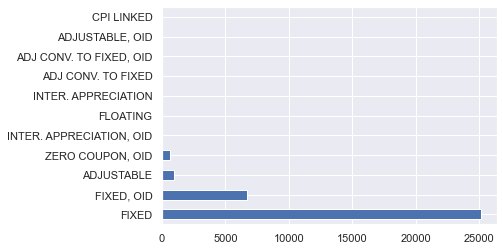

In [72]:

muni_df["cpnTyp"].value_counts().plot(kind = 'barh');

In [73]:
muni_df = muni_df[muni_df.apply(lambda x: x["cpnTyp"] in ['FIXED', 'FIXED, OID', 'ZERO COUPON, OID',],axis=1)]

In [74]:
len(muni_df)

32487

##### First Coupon date is present for all bonds, for zero coupon dates have to check bloomberg documentation to see what it means.

In [75]:
muni_df[muni_df["firstCpnDt"].isnull()]["yield"]

Series([], Name: yield, dtype: float64)

##### Total number of trades on Oct-27  and total unique cusips traded that day for which we have reference data.

In [76]:
len(muni_df),len(muni_df["cusip"].unique())

(32487, 13211)

##### Coupon of 0 is given to zero coupon bonds. One interesting observation is that the coupon Frequency for zeros is 2. This might be because of the convention to qoute ytm on a semiannual compunding basis

In [77]:
muni_df[(muni_df["cpn"] != 0) ].head()

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date
162,2020-10-29,105.740,0.704,011770W42,4.0,P,2,2022-08-01,100.0,2023-08-01,2020-08-01,2021-02-01,2012-08-01,2020-10-27,13329,2020102702987000,FIXED,2020-10-27
163,2020-10-29,116.117,0.734,033161U57,5.0,P,2,2024-09-01,100.0,2025-09-01,2020-09-01,2021-03-01,2015-03-01,2020-10-27,8226,2020102701894700,FIXED,2020-10-27
164,2020-10-29,112.476,1.345,576544N71,5.0,D,2,2024-05-01,100.0,2029-11-01,2020-05-01,2020-11-01,2014-11-01,2020-10-27,27132,2020102705985100,FIXED,2020-10-27
165,2020-10-29,112.476,1.345,576544N71,5.0,P,2,2024-05-01,100.0,2029-11-01,2020-05-01,2020-11-01,2014-11-01,2020-10-27,27135,2020102705985800,FIXED,2020-10-27
166,2020-10-29,102.618,0.540,662523ZP7,5.0,P,2,2021-06-01,100.0,2021-06-30,2020-06-30,2020-12-30,2015-06-30,2020-10-27,23298,2020102705181400,FIXED,2020-10-27


##### Changing data types for date columns. Taking only issues which has not matured yet.

In [78]:
start_date = datetime.strptime("2020-10-27",'%Y-%m-%d')
muni_df["prevCpnDt"] = pd.to_datetime(muni_df["prevCpnDt"])
muni_df["nxtCpnDt"] = pd.to_datetime(muni_df["nxtCpnDt"])
muni_df["maturity"] = pd.to_datetime(muni_df["maturity"])
# muni_df["nxtCallDt"] = muni_df["nxtCallDt"].astype(str)
# muni_df = muni_df[muni_df["maturity"] > start_date]
# muni_df["maturity"].head()

#### 48 trades on 11 bonds have maturity date lesser than the date of trade, these are distressed securities and we remove them from our analysis.

In [79]:
len(muni_df[muni_df["maturity"] < start_date]),len(muni_df[muni_df["maturity"] < start_date]["cusip"].unique())

(0, 0)

In [80]:
len(muni_df)

32487

##### We take bonds which have maturity date greater than trade date

In [81]:
muni_df = muni_df[muni_df["maturity"] > start_date]

#### 213 trades have missing yield from MSRB

In [82]:
#Number of missing values for yield
len(muni_df[muni_df["yield"].isnull()])

18

In [83]:
#Number of missing values for coupon
len(muni_df[muni_df["cpn"].isnull()])

0

In [84]:
muni_df["yield"].describe()

count    32469.000000
mean         1.473091
std          2.605121
min        -67.341000
25%          0.658000
50%          1.280000
75%          2.155000
max         94.015000
Name: yield, dtype: float64

##### Records corresponding to maximum yield as per MSRB calculations

In [85]:
muni_df[muni_df["yield"]==muni_df["yield"].max()]

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date
10158,2020-10-29,5.712,94.015,073009AG7,5.375,D,2,2020-11-27,100.0,2035-11-01,2020-05-01,2020-11-01,2006-11-01,2020-10-27,989,2020102700193200,FIXED,2020-10-27
10159,2020-10-29,5.712,94.015,073009AG7,5.375,D,2,2020-11-27,100.0,2035-11-01,2020-05-01,2020-11-01,2006-11-01,2020-10-27,749,2020102700193200,FIXED,2020-10-27


##### Records corresponding to minimum yield as per MSRB calculations

In [86]:
muni_df[muni_df["yield"]==muni_df["yield"].min()]

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date
9832,2020-10-29,105.751,-67.341,544525BB3,4.25,D,2,2020-11-27,100.0,2030-10-15,2020-10-15,2021-04-15,1999-04-15,2020-10-27,10337,2020102702351900,"FIXED, OID",2020-10-27


In [87]:
#Number of cusips with no next call date
print(len(muni_df[muni_df["nxtCallDt"].isnull()]["cusip"].unique()))
print(len(muni_df[muni_df["nxtCallDt"].isnull()]))

5368
11519


In [88]:
#Number of cusips with no maturity date
len(muni_df[muni_df["maturity"].isnull()])

0

In [89]:
#Number of records with no par price
print(len(muni_df[muni_df["nxtCallPx"].isnull()]["cusip"].unique()))
print(len(muni_df[muni_df["nxtCallPx"].isnull()]))


5368
11519


In [90]:
print(muni_df["nxtCallPx"].describe())

count    20968.000000
mean        99.776874
std          3.622214
min         16.614000
25%        100.000000
50%        100.000000
75%        100.000000
max        105.000000
Name: nxtCallPx, dtype: float64


In [91]:
print(muni_df["cpn"].describe())

count    32487.000000
mean         4.075696
std          1.282143
min          0.000000
25%          3.125000
50%          4.500000
75%          5.000000
max         10.000000
Name: cpn, dtype: float64


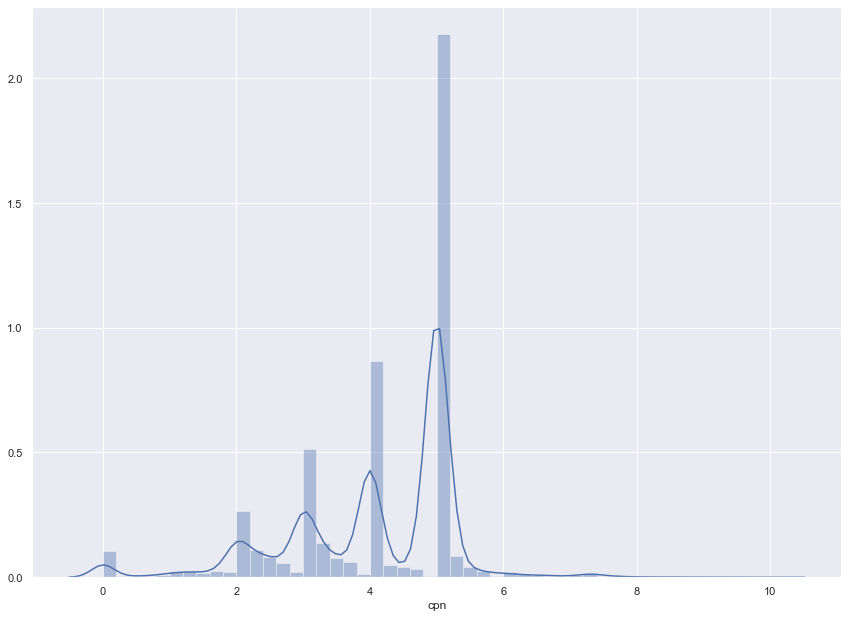

In [92]:
sns.distplot(muni_df["cpn"]);
fig = plt.gcf()
fig.set_size_inches(14.5, 10.5)

##### Unique Frequencies presend in the dataset.

In [93]:
muni_df.groupby("cpnFreq").apply(lambda x:len(x["cusip"].unique()))

cpnFreq
1        34
2     13169
4         5
12        3
dtype: int64

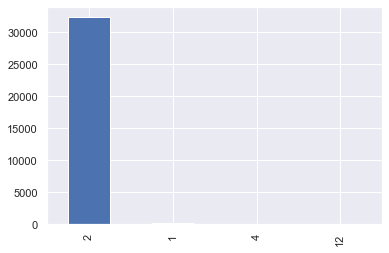

In [94]:
muni_df["cpnFreq"].value_counts().plot(kind = 'bar');

In [110]:
def diff_in_years(end_date,start_date,days_in_year):
     difference_in_years = relativedelta(end_date, start_date).years + relativedelta(end_date, start_date).months/12 + relativedelta(end_date, start_date).days/days_in_year
     return difference_in_years


def get_previous_next_cpn_date(first_cpn_date,start_date,time_delta):
     date = first_cpn_date
     while date < start_date:
            date = date + time_delta
    
     next_cpn_date = date
     prev_cpn_date = date - time_delta
     return prev_cpn_date,next_cpn_date


In [111]:
def get_yield(coupon,frequency,dt,par,dollar_price,guess,difference_in_years,):
    if len(dt)>0:
        ytm_func = lambda y: sum([coupon/((1+y/frequency)**(1*t)) for t in dt]) + par/((1+y/frequency)**(1*dt[len(dt)-1])) - dollar_price
    else:
        ytm_func = lambda y: par/((1+y/frequency)**(frequency*difference_in_years)) - dollar_price
    try:
        return round((optimize.newton(ytm_func, guess,maxiter = 100))*100,5)
    except Exception as e:
        print(e)
        return None

In [112]:
def compute_yield(cpn,par,first_cpn_date,start_date,time_delta,end_date,no_coupon,dollar_price,days_in_year,frequency):
    periods = 0
    if cpn!=0:
        
        first_cpn_date = pd.to_datetime(first_cpn_date)
        if first_cpn_date<start_date:
            prev_cpn_date,next_cpn_date = get_previous_next_cpn_date(first_cpn_date,start_date,time_delta)
            # accrued_interest = coupon*(diff_in_years(start_date,prev_cpn_date,days_in_year)/diff_in_years(next_cpn_date,               prev_cpn_date,days_in_year))
        else:
            next_cpn_date = first_cpn_date
        date = next_cpn_date
        while date < end_date:
            periods += 1
            date = date + time_delta

        if no_coupon == False:
            periods = periods + 1
        if date == end_date:
            periods+=1
        
        # not pd.isnull(next_cpn_date) and not pd.isnull(prev_cpn_date) and cpn != 0

    dt = [(i+1) for i in range(int(periods))]
    difference_in_years = diff_in_years(end_date,start_date,days_in_year)
    bond_yield = get_yield(cpn,frequency,dt,par,dollar_price,guess,difference_in_years,)

    return bond_yield

In [113]:
def new_bond_ytw(cusip,dollar_price,nxtCallPx,start_date,call_date,maturity_date,first_cpn_date,cpn,frequency,guess):
    
    days_in_year = 360
    coupon = float(cpn)/int(frequency)
    ytf = float("-inf")
    ytm = float("-inf")
    frequency = int(frequency)
    
    if frequency <= 12:
        delta = 12//frequency
        time_delta = relativedelta(months=+delta)
    elif frequency > 12 and frequency <= 52:
        delta = 52//frequency
        time_delta = relativedelta(weeks=+delta)
        

#     issue_with_call = 
    if (issubclass(type(call_date), type(pd.NaT)) or pd.isnull(call_date)) or (issubclass(type(nxtCallPx),type(pd.NaT)) or pd.isnull(nxtCallPx)):
        end_date = maturity_date
        par = 100
        no_coupon = False
        ytm = compute_yield(coupon,par,first_cpn_date,start_date,time_delta,end_date,no_coupon,dollar_price,days_in_year,frequency)
        return ytm
    else:
        end_date = call_date
        par = nxtCallPx
        no_coupon = True
        ytf = compute_yield(coupon,par,first_cpn_date,start_date,time_delta,end_date,no_coupon,dollar_price,days_in_year,frequency)
        end_date = maturity_date
        par = 100
        no_coupon = False
        ytm = compute_yield(coupon,par,first_cpn_date,start_date,time_delta,end_date,no_coupon,dollar_price,days_in_year,frequency)
        if ytm < ytf:
            return ytm
        else:
            return ytf
        
        
        
   
    # Different logic for zero-coupon bond and fixed coupon bond.
    

    

In [114]:
# # Take Actual/Actual convention.
# def bond_ytw(cusip,dollar_price,par,start_date,call_date,maturity_date,first_cpn_date,cpn,frequency,guess):
#     # print(cusip,dollar_price,par,start_date,call_date,maturity_date,next_cpn_date,prev_cpn_date,cpn,frequency,guess)
#     # print("\n")
#     # call_date = maturity_date
#     periods = 0
#     days_in_year = 365
#     no_coupon = False
#     delta = 12/int(frequency)
#     coupon = float(cpn)/int(frequency)

#     #Logic to decide end date
#     if issubclass(type(call_date), type(pd.NaT)) or pd.isnull(call_date):
#         end_date = maturity_date
#         par = 100
#     else:
#         if dollar_price > 100:
#             end_date = call_date
#             if issubclass(type(par),type(pd.NaT)) or pd.isnull(par):
#                 par = 100
#             no_coupon = True
#         else:
#             end_date = maturity_date
#             par = 100
#     # Different logic for zero-coupon bond and fixed coupon bond.
#     if cpn!=0:
#         first_cpn_date = pd.to_datetime(first_cpn_date)
#         if first_cpn_date<start_date:
#             prev_cpn_date,next_cpn_date = get_previous_next_cpn_date(first_cpn_date,start_date,delta)
#             # accrued_interest = coupon*(diff_in_years(start_date,prev_cpn_date,days_in_year)/diff_in_years(next_cpn_date,               prev_cpn_date,days_in_year))
#         else:
#             next_cpn_date = first_cpn_date
#             # accrued_interest = 0

#         # dollar_price += accrued_interest
#         date = next_cpn_date
#         if frequency <= 12:
#             delta = 12//frequency
#             while date <= end_date:
#                 periods += 1
#                 date = date + relativedelta(months=+delta)
#         elif frequency > 12 and frequency <=52:
#             delta = 52//frequency
#             while date <= end_date:
#                 periods += 1
#                 date = date + relativedelta(weeks=+delta)
#         elif frequency>52:
#             delta = 365//frequency
#             while date <= end_date:
#                 periods += 1
#                 date = date + relativedelta(days=+delta)
#         # if prev_cpn_date<start_date:
#         #     periods = periods - 1
#         if no_coupon == True:
#             periods = periods - 1

#     else:
#         end_date = maturity_date
#         periods = 0
#     # not pd.isnull(next_cpn_date) and not pd.isnull(prev_cpn_date) and cpn != 0

#     dt = [(i+1) for i in range(int(periods))]
#     difference_in_years = diff_in_years(end_date,start_date,days_in_year)
#     bond_yield = get_yield(coupon,frequency,dt,par,dollar_price,guess,difference_in_years,)

#     return bond_yield

#         # print(par,cpn,coupon,frequency,dt,difference_in_years,start_date,end_date,periods,maturity_date,cusip,call_date)
    

    


    

In [115]:
from pandas import NaT
start_date = datetime.strptime("2020-10-27",'%Y-%m-%d')
# print(type(start_date))
guess = 0.05
# (cusip,dollar_price,par,start_date,call_date,maturity_date,next_cpn_date,prev_cpn_date,cpn,frequency,guess)

muni_df["computed_ytw"] = muni_df.progress_apply(lambda x: new_bond_ytw(x['cusip'],x['dollar_price'],x['nxtCallPx'],x['trade_date'],x['nxtCallDt'],x['maturity'],x['firstCpnDt'],x['cpn'],x['cpnFreq'],guess,),axis=1)

##### Visualizing the computed YTW and MSRB yield

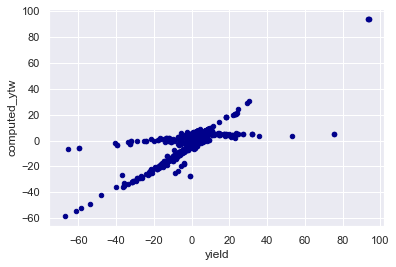

In [106]:
ax1 = muni_df.plot.scatter(x='yield',
                     y='computed_ytw',
                       c='DarkBlue')

In [109]:
muni_df["computed_ytw"].unique()

array([ 1.0900e+00,  8.9000e-01,  1.7600e+00, -2.3000e-01,  1.5800e+00,
        1.0300e+00, -4.6000e+00,  2.7500e+00,  1.1800e+00,  1.5200e+00,
        2.0900e+00,  1.9800e+00,  1.9600e+00,  1.4300e+00,  1.7800e+00,
        1.7900e+00,  1.2200e+00,  1.1400e+00,  2.0200e+00,  2.0700e+00,
        1.9100e+00,  2.4400e+00,  2.3200e+00,  6.7000e-01,  6.2000e-01,
        7.1000e-01,  5.7000e-01,  4.1000e-01,  1.1200e+00,  1.1600e+00,
        1.0600e+00,  1.1700e+00,  1.0500e+00,  1.6700e+00,  1.6800e+00,
        1.7700e+00,  1.8200e+00,  1.6500e+00,  1.5900e+00,  1.8300e+00,
        7.6000e-01,  8.0000e-01,  7.3000e-01,  7.4000e-01,  8.1000e-01,
        9.0000e-01,  6.3000e-01,  7.0000e-01,  6.9000e-01,  6.8000e-01,
        1.0100e+00,  9.9000e-01,  2.4800e+00,  1.1500e+00,  6.0000e-01,
        6.4000e-01,  9.8000e-01,  5.8000e-01,  5.3000e-01,  5.2000e-01,
        1.2800e+00,  1.3000e+00,  1.2900e+00,  1.3200e+00,  1.3400e+00,
        1.3300e+00,  1.4000e+00,  1.1900e+00,  1.3100e+00,  1.53

In [108]:
muni_df[muni_df["computed_ytw"] == None]

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date,computed_ytw


In [49]:
print(muni_df["computed_ytw"].describe())
print("****************")
print(muni_df["yield"].describe())

count    32487.000000
mean         1.901124
std          2.760231
min        -95.920000
25%          1.250000
50%          1.780000
75%          2.480000
max        114.780000
Name: computed_ytw, dtype: float64
****************
count    32469.000000
mean         1.473091
std          2.605121
min        -67.341000
25%          0.658000
50%          1.280000
75%          2.155000
max         94.015000
Name: yield, dtype: float64


##### Records corresponding to maximum computed yield. WE can say that the bond matures in 4 days. and it is being traded a huge discount. I am confused why is this the case is it because the bond defualted or the redemption price is low (will have to check.)

In [50]:
muni_df[muni_df["computed_ytw"] == max(muni_df["computed_ytw"])]

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date,computed_ytw
6050,2020-10-27,4.367,NaN,984402KT3,5.0,P,2,2028-06-01,100.0,2029-12-01,2020-06-01,2020-12-01,2019-06-01,2020-10-27,4732,2020102701136000,FIXED,2020-10-27,114.78
6051,2020-10-27,4.367,NaN,984402KT3,5.0,P,2,2028-06-01,100.0,2029-12-01,2020-06-01,2020-12-01,2019-06-01,2020-10-27,5623,2020102701136000,FIXED,2020-10-27,114.78


##### Analyzing records with yield between 0% and 10%

In [51]:
new_data = muni_df[(muni_df["yield"]>0) & (muni_df["yield"]<10)]

In [52]:
len(new_data)

32003

In [53]:
new_data["computed_ytw"].corr(new_data["yield"])

0.7336550611818883

#### There is lot of dispersion when MSRB yield computed is 0.

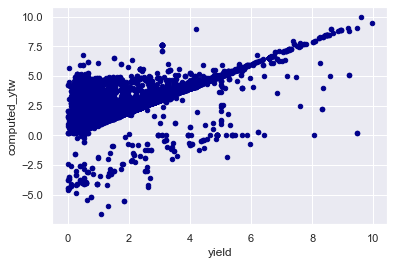

In [54]:
ax1 = new_data.plot.scatter(x='yield',
                     y='computed_ytw',
                       c='DarkBlue')

##### Records with msrb yield = 0

In [55]:
zero_cpn_case = muni_df[(muni_df["yield"]==0) & (muni_df["cpn"]==0) ]

In [56]:
len(zero_cpn_case)

4

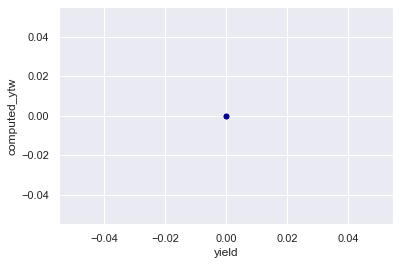

In [57]:
ax1 = zero_cpn_case.plot.scatter(x='yield',
                     y='computed_ytw',
                       c='DarkBlue')

In [58]:
cpn_case_maturity = muni_df[(muni_df["yield"]==0) & (muni_df["dollar_price"]>100) ]

In [59]:
len(cpn_case_maturity)

5

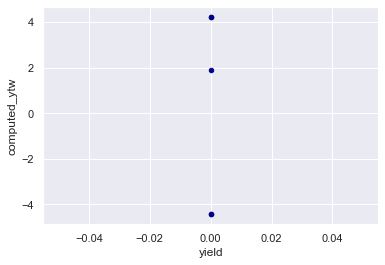

In [60]:
ax1 = cpn_case_maturity.plot.scatter(x='yield',
                     y='computed_ytw',
                       c='DarkBlue')

In [61]:
cpn_case_maturity.head()

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date,computed_ytw
2722,2020-10-27,100.375,0.0,207758LL5,5.0,D,2,2020-11-27,100.0,2022-11-01,2020-05-01,2020-11-01,2011-05-01,2020-10-27,31628,2020102707008400,FIXED,2020-10-27,4.23
2723,2020-10-27,100.375,0.0,207758LL5,5.0,S,2,2020-11-27,100.0,2022-11-01,2020-05-01,2020-11-01,2011-05-01,2020-10-27,31615,2020102707005000,FIXED,2020-10-27,4.23
12106,2020-10-27,107.527,0.0,97705MFB6,5.0,S,2,None,NaN,2022-05-01,2020-05-01,2020-11-01,2017-05-01,2020-10-27,11731,2020102702639200,FIXED,2020-10-27,1.90
17703,2020-10-27,100.375,0.0,6180234B8,5.0,D,2,2020-11-27,100.0,2022-09-15,2020-09-15,2021-03-15,2012-03-15,2020-10-27,31629,2020102707008700,FIXED,2020-10-27,-4.44
17704,2020-10-27,100.375,0.0,6180234B8,5.0,S,2,2020-11-27,100.0,2022-09-15,2020-09-15,2021-03-15,2012-03-15,2020-10-27,31584,2020102706997000,FIXED,2020-10-27,-4.44


In [62]:
len(muni_df[muni_df["yield"]==0 ])

9

In [63]:
# (cusip,dollar_price,par,start_date,call_date,maturity_date,next_cpn_date,prev_cpn_date,cpn,frequency,guess)
#print(end_date,no_coupon,coupon,dt,difference_in_years)

In [120]:
muni_df[(muni_df["yield"] - muni_df["computed_ytw"])>10][["trade_date","dollar_price","yield","cpn","cpnFreq","nxtCallDt","nxtCallPx","maturity","nxtCpnDt","computed_ytw"]].head()

,trade_date,dollar_price,yield,cpn,cpnFreq,nxtCallDt,nxtCallPx,maturity,nxtCpnDt,computed_ytw
1525,2020-10-28,102.450,-0.762,4.5,2,2020-11-27,100.0,2024-04-15,2021-04-15,-27.03500
1526,2020-10-28,102.450,-0.762,4.5,2,2020-11-27,100.0,2024-04-15,2021-04-15,-27.03500
5111,2020-10-28,99.400,75.595,5.0,2,2020-11-01,100.0,2022-11-01,2020-11-01,5.21866
5113,2020-10-28,99.400,75.595,5.0,2,2020-11-01,100.0,2022-11-01,2020-11-01,5.21866
5626,2020-10-28,99.886,18.252,5.0,2,2020-11-01,100.0,2022-11-01,2020-11-01,5.04142


In [118]:
muni_df[(muni_df["yield"] - muni_df["computed_ytw"])<-10][["trade_date","dollar_price","yield","cpn","cpnFreq","nxtCallDt","nxtCallPx","maturity","nxtCpnDt","computed_ytw"]].head()

,trade_date,dollar_price,yield,cpn,cpnFreq,nxtCallDt,nxtCallPx,maturity,nxtCpnDt,computed_ytw
3150,2020-10-29,101.400,-13.457,4.750,2,2020-11-27,100.0,2022-05-01,2020-11-01,1.92308
3151,2020-10-29,101.400,-13.457,4.750,2,2020-11-27,100.0,2022-05-01,2020-11-01,1.92308
3152,2020-10-29,103.012,-33.714,4.750,2,2020-11-27,100.0,2022-05-01,2020-11-01,-1.23675
6290,2020-10-29,101.360,-13.074,4.625,2,2020-11-27,100.0,2022-05-01,2020-11-01,1.87944
6291,2020-10-29,101.550,-15.497,4.625,2,2020-11-27,100.0,2022-05-01,2020-11-01,1.50172


In [119]:
muni_df[(muni_df["yield"]<0) & (muni_df['computed_ytw']>0)][["trade_date","dollar_price","yield","cpn","cpnFreq","nxtCallDt","nxtCallPx","maturity","nxtCpnDt","computed_ytw"]].head()

,trade_date,dollar_price,yield,cpn,cpnFreq,nxtCallDt,nxtCallPx,maturity,nxtCpnDt,computed_ytw
2224,2020-10-28,104.005,-0.829,5.00,2,2021-03-01,102.0,2027-03-01,2021-03-01,0.95188
3150,2020-10-29,101.400,-13.457,4.75,2,2020-11-27,100.0,2022-05-01,2020-11-01,1.92308
3151,2020-10-29,101.400,-13.457,4.75,2,2020-11-27,100.0,2022-05-01,2020-11-01,1.92308
4982,2020-10-29,100.869,-0.045,5.00,2,2021-01-01,100.0,2023-01-01,2021-01-01,3.23390
5134,2020-10-29,102.221,-2.463,5.00,2,2021-02-15,100.0,2025-02-15,2021-02-15,0.54588


In [206]:
muni_df[(muni_df["yield"]>0) & (muni_df['computed_ytw']<0)].head()

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date,computed_ytw
166,2020-10-27,102.618,0.540,662523ZP7,5.0,P,2,2021-06-01,100.0,2021-06-30,2020-06-30,2020-12-30,2015-06-30,2020-10-27,23298,2020102705181400,FIXED,2020-10-27,-0.23
197,2020-10-27,106.612,0.388,13063BL67,4.0,D,2,2022-09-01,100.0,2026-09-01,2020-09-01,2021-03-01,2013-03-01,2020-10-27,6965,2020102701627800,FIXED,2020-10-27,-0.39
198,2020-10-27,106.712,0.335,13063BL67,4.0,D,2,2022-09-01,100.0,2026-09-01,2020-09-01,2021-03-01,2013-03-01,2020-10-27,25396,2020102705615200,FIXED,2020-10-27,-0.45
199,2020-10-27,106.512,0.440,13063BL67,4.0,D,2,2022-09-01,100.0,2026-09-01,2020-09-01,2021-03-01,2013-03-01,2020-10-27,25394,2020102705605600,FIXED,2020-10-27,-0.33
200,2020-10-27,106.812,0.283,13063BL67,4.0,S,2,2022-09-01,100.0,2026-09-01,2020-09-01,2021-03-01,2013-03-01,2020-10-27,6956,2020102701626000,FIXED,2020-10-27,-0.52


In [208]:
muni_df[(muni_df["yield"]<0) & (muni_df['computed_ytw']>0)].head()

,trade_date,dollar_price,yield,cusip,cpn,trade_type,cpnFreq,nxtCallDt,nxtCallPx,maturity,prevCpnDt,nxtCpnDt,firstCpnDt,upload_date,sequence_number,rtrs_control_number,cpnTyp,publish_date,computed_ytw
3150,2020-10-27,101.4,-13.457,020141KM8,4.75,D,2,2020-11-27,100.0,2022-05-01,2020-05-01,2020-11-01,2007-05-01,2020-10-27,2758,2020102700684800,FIXED,2020-10-27,1.92
3151,2020-10-27,101.4,-13.457,020141KM8,4.75,P,2,2020-11-27,100.0,2022-05-01,2020-05-01,2020-11-01,2007-05-01,2020-10-27,2691,2020102700684700,FIXED,2020-10-27,1.92
5630,2020-10-27,100.6,-2.643,92818MTQ3,5.00,D,2,2020-11-27,100.0,2022-11-01,2020-05-01,2020-11-01,2011-05-01,2020-10-27,12094,2020102702713700,FIXED,2020-10-27,3.78
5877,2020-10-27,100.4,-0.814,130178SU1,4.50,D,2,2020-11-27,100.0,2021-11-01,2020-05-01,2020-11-01,2009-11-01,2020-10-27,5394,2020102701267700,"FIXED, OID",2020-10-27,3.69
5878,2020-10-27,100.5,-2.116,130178SU1,4.50,D,2,2020-11-27,100.0,2021-11-01,2020-05-01,2020-11-01,2009-11-01,2020-10-27,5395,2020102701280800,"FIXED, OID",2020-10-27,3.48


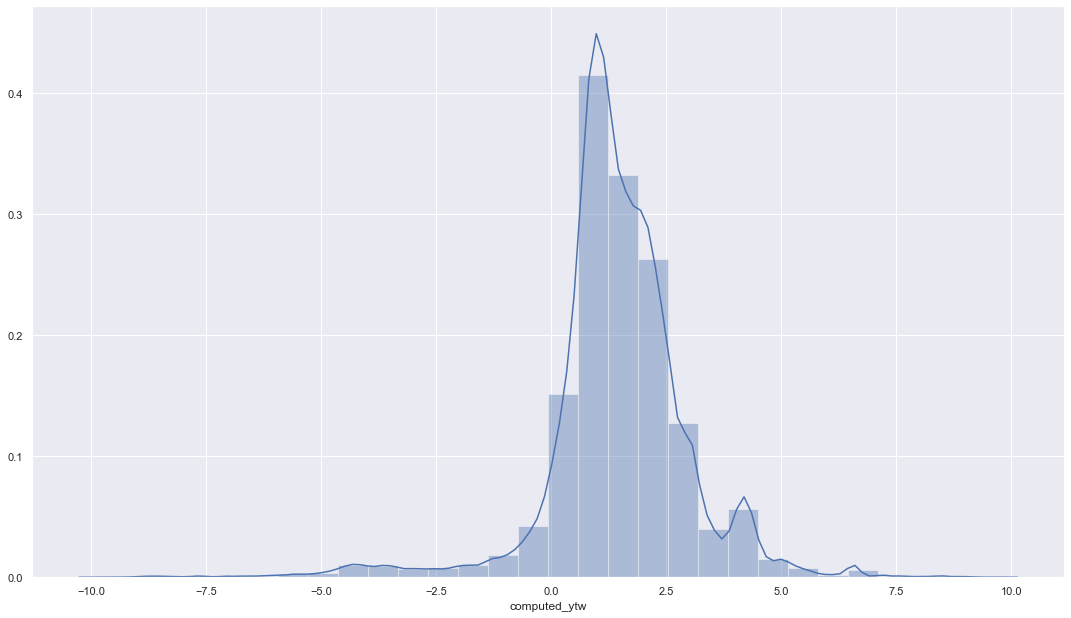

In [229]:
sns.distplot(muni_df[(muni_df["computed_ytw"]<10) & (muni_df["computed_ytw"]>-10)]["computed_ytw"],bins=30)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

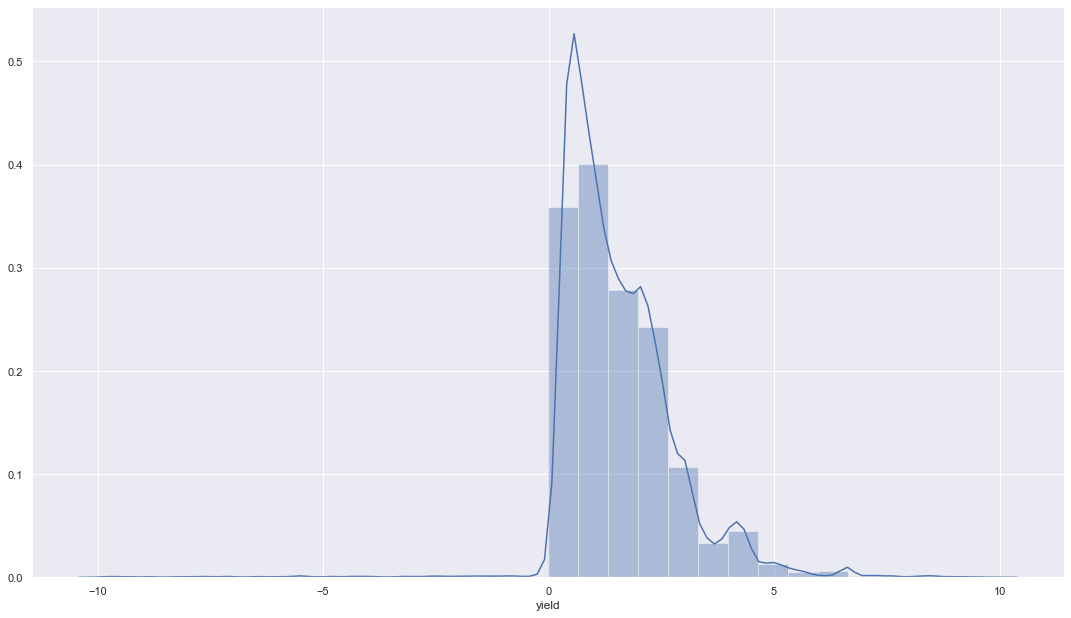

In [228]:
sns.distplot(muni_df[(muni_df["yield"]<10) & (muni_df["yield"]>-10)]["yield"],bins=30);
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)  

In [233]:
muni_df[(muni_df["cpn"]==0)][["dollar_price","yield","cpn","cusip","nxtCallDt","maturity","computed_ytw"]].head(100)

,dollar_price,yield,cpn,cusip,nxtCallDt,maturity,computed_ytw
1758,71.077,0.781,0.0,03667PEM0,2025-02-01,2032-08-01,0.75
1769,51.673,1.870,0.0,088023MB9,2026-08-01,2039-08-01,1.87
1770,51.423,1.955,0.0,088023MB9,2026-08-01,2039-08-01,1.95
1900,46.855,2.420,0.0,204709JA8,2028-08-01,2040-08-01,2.42
1913,88.064,0.764,0.0,152339KQ9,2021-08-01,2023-08-01,0.76
...,...,...,...,...,...,...,...
11927,75.407,2.399,0.0,03255LBS7,None,2032-09-01,2.40
11928,74.807,2.467,0.0,03255LBS7,None,2032-09-01,2.47
11929,74.807,2.467,0.0,03255LBS7,None,2032-09-01,2.47
11930,74.707,2.478,0.0,03255LBS7,None,2032-09-01,2.48


#### Loading data to bigquery table

In [551]:
def create_table_with_schema(bq,project_id,dataset,table_id,schema = None):
    PROJECT = project_id
    bq = bq
    table_id = '{}.{}.{}'.format(PROJECT,dataset,table_id)
    table = bq.create_table(table_id, exists_ok=True)
    print('{} created on {}'.format(table.table_id, table.created))
    table = bq.get_table(table_id)
    table.schema = schema
    table = bq.update_table(table, ["schema"])

In [552]:
def load_data(bq,data,project,dataset,table):
    bq = bq
    table_id = '{}.{}.{}'.format(project,dataset,table)
    job_config = bigquery.LoadJobConfig(schema = table_schema.get_table_schema(table))
    job = bq.load_table_from_dataframe(data, table_id,job_config=job_config)

    try:
        job.result() # Waits for the job to complete.
        return 'success'  
    except BadRequest as ex:
        print(ex) 

In [553]:
muni_df.columns

Index(['trade_date', 'dollar_price', 'yield', 'cusip', 'cpn', 'cpnFreq',
       'nxtCallDt', 'nxtCallPx', 'maturity', 'prevCpnDt', 'nxtCpnDt',
       'firstCpnDt', 'upload_date', 'sequence_number', 'rtrs_control_number',
       'cpnTyp', 'publish_date', 'computed_ytw'],
      dtype='object')

In [554]:
# SELECT trade_date,dollar_price,yield,cusip,bb.cpn,bb.cpnFreq,bb.nxtCallDt,bb.nxtCallPx,bb.maturity,                        bb.prevCpnDt,bb.nxtCpnDt,bb.firstCpnDt,msrb.upload_date,msrb.sequence_number,msrb.rtrs_control_number,                    bb.cpnTyp

In [555]:
schema = [ bigquery.SchemaField("trade_date","DATE"),	
                bigquery.SchemaField("dollar_price","FLOAT64"),
                bigquery.SchemaField("yield","FLOAT64"),	
                bigquery.SchemaField("computed_ytw","FLOAT64"),
                bigquery.SchemaField("msrb_upload_date","DATE"),
                bigquery.SchemaField("msrb_sequence_number","STRING"),
                bigquery.SchemaField("msrb_rtrs_control_number","STRING"),
                bigquery.SchemaField("msrb_publish_date","DATE"),]  

In [556]:
PROJECT = 'eng-reactor-287421'
dataset = 'MSRB'
table = 'msrb_with_ytw'

In [557]:
create_table_with_schema(bqclient,PROJECT,dataset,table,schema)

msrb_with_ytw created on 2020-11-08 20:29:21.125000+00:00


In [558]:
data = muni_df[["trade_date","dollar_price","yield","computed_ytw","upload_date","sequence_number","rtrs_control_number","publish_date"]]

In [559]:
data = data.rename(columns = {"upload_date":"msrb_upload_date","rtrs_control_number":"msrb_rtrs_control_number","publish_date":"msrb_publish_date","sequence_number":"msrb_sequence_number"})

In [560]:
# data["msrb_publish_time"].apply(lambda x: x.time())
#  = data["msrb_rtrs_control_number"].astype(str)

In [561]:
data["msrb_rtrs_control_number"] = data["msrb_rtrs_control_number"].astype(str)
data["msrb_sequence_number"] = data["msrb_sequence_number"].astype(str)

In [562]:

load_data(bqclient,data,PROJECT,dataset,table)

'success'

In [421]:
# # Function to compute yield to first(Yield to First) of all bonds (Uses 30/360 day count convention):
# def bond_ytf(cusip,price, par, start_date,call_date,maturity_date, coup, freq=2, guess=0.05):
#     no_coupon = False
#     if issubclass(type(call_date), type(pd.NaT)) or pd.isnull(call_date):
#         end_date = maturity_date
#         par = 100
#     else:
#         end_date = call_date
#         no_coupon = True
#     if issubclass(type(par),type(pd.NaT)):
#         par = 100
#     price = float(price)

#     # if price > 100:
        
#     #     end_date = call_date

        
#     # elif price <= 100:
#     #     # print("price is lesser")
#     #     end_date = maturity_date
 
#         # print(end_date)
#     # print(end_date)
#     # print("end_date" + str(type(end_date)))
#     # print("start_date" + str(type(start_date)))
#     # end_date = datetime.strptime(end_date,'%Y-%m-%d')
#     # start_date = datetime.strptime(start_date,'%Y-%m-%d')
#     # if end_date>start_date:
#     #     print("difference")
#     #     print(end_date)
#     #     print(start_date)
#     # print(type(end_date))
#     difference_in_years = relativedelta(end_date, start_date).years + relativedelta(end_date, start_date).months/12 + relativedelta(end_date, start_date).days/days_in_year
#     # print(cusip)
#     frequency = int(freq)
#     # print(frequency)
#     coupon = ((coup/100)*par)/frequency
#     # print(coupon)
#     periods = math.ceil(difference_in_years*frequency)
#     # print(periods)
#     dt = [(i+1) for i in range(int(periods))]
#     # print(len(dt))
   
#     if no_coupon:
#         ytm_func = lambda y: sum([coupon/((1+y/frequency)**(t)) for t in dt]) + par/((1+y/frequency)**                    (dt[len(dt)-1])) - price - coupon/((1+y/frequency)**(dt[len(dt)-1]))
#     else:
#         ytm_func = lambda y: sum([coupon/((1+y/frequency)**(t)) for t in dt]) + par/((1+y/frequency)**                    (dt[len(dt)-1])) - price
#     try:
#         return (optimize.newton(ytm_func, guess,maxiter = 150))*100
#     except Exception as e:
#         print(e)
#         print(coup,coupon,frequency,dt,periods,end_date,maturity_date,cusip,type(call_date))
#         return 0



In [231]:
# # Function to compute yield to worst(YTW) of all bonds (Uses 30/360 day count convention):
# days_in_year = 360
# def bond_ytm(cusip,price, par, start_date,call_date,maturity_date,nxtcpndate, coup, freq=2, guess=0.05):
#     no_coupon = False
#     if issubclass(type(call_date), type(pd.NaT)) or pd.isnull(call_date):
#         # print("issue")
#         end_date = maturity_date
#         par = 100
#     else:
#         if price > 100:
#             end_date = call_date
#             no_coupon = True
#         else:
#             end_date = maturity_date

       
#     if issubclass(type(par),type(pd.NaT)):
#         par = 100
#     price = float(price)

#     # if price < 100:
        
        

        
#     # elif price <= 100:
#     #     end_date = maturity_date
 
#         # print(end_date)
#     # print(end_date)
#     # print("end_date" + str(type(end_date)))
#     # print("start_date" + str(type(start_date)))
#     # end_date = datetime.strptime(end_date,'%Y-%m-%d')
#     # start_date = datetime.strptime(start_date,'%Y-%m-%d')
#     # if end_date>start_date:
#     #     print("difference")
#     #     print(end_date)
#     #     print(start_date)
#     # print(type(end_date))
#     difference_in_years = relativedelta(end_date, start_date).years + relativedelta(end_date, start_date).months/12 + relativedelta(end_date, start_date).days/days_in_year
#     difference_to_next_cpn = relativedelta(nxtcpndate, start_date).years + relativedelta(nxtcpndate, start_date).months/12 + relativedelta(nxtcpndate, start_date).days/days_in_year
#     # print(cusip)
#     frequency = int(freq)
#     # print(frequency)
#     coupon = ((coup/100)*par)/frequency
#     # print(coupon)
#     periods = difference_in_years*frequency
#     if difference_to_next_cpn<difference_in_years :
#         periods = math.floor(periods) + 1

#     else:
#         periods = math.floor(periods)
        
#     # print(periods)
#     # if no_coupon:
#     dt = [(i+1) for i in range(int(periods))]
#     # else:
#         # dt = [(i+difference_to_next_cpn*frequency) for i in range(int(periods))]
#     # print(len(dt))
#     print(end_date,dt,coup,coupon,difference_in_years,difference_to_next_cpn,frequency,dt,periods,end_date,maturity_date,cusip,type(call_date))
#     # - coupon/((1+y/frequency)**(dt[len(dt)-1]))
#     if len(dt)>0:
#         ytm_func = lambda y: sum([coupon/((1+y/frequency)**(t)) for t in dt]) + par/((1+y/frequency)**                    (difference_in_years*frequency)) - price 
#     else:
#         ytm_func = lambda y:  par/((1+y/frequency)**(difference_in_years*frequency)) - price 
#     try:
#         return (optimize.newton(ytm_func, guess,maxiter = 150))*100
#     except Exception as e:
#         print(e)
#         print(coup,coupon,frequency,dt,periods,end_date,maturity_date,cusip,type(call_date))
#         return 0



In [ ]:
# cusip = "xyz"
# price = 5.712
# par = 100
# freq = 2
# start_date = datetime.strptime("2020-10-27",'%Y-%m-%d')
# call_date = datetime.strptime("2020-11-27",'%Y-%m-%d')
# maturity_date = datetime.strptime("2022-08-15",'%Y-%m-%d')
# nxt_cpn_date = datetime.strptime("2020-11-01",'%Y-%m-%d')
# prev_cpn_date = datetime.strptime("2020-05-01",'%Y-%m-%d')
# coup = 5.375
# bond_ytw(cusip,price, par, start_date,call_date,maturity_date,nxt_cpn_date,prev_cpn_date, coup, freq, guess)